In [11]:
import os
import cv2
import matplotlib.pyplot as plt
import open3d as o3d
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pickle


import matplotlib
import gtsam
import scipy
import tqdm
import gtsam.utils.plot as gtsam_plot
import math
import itertools

In [12]:
directory = './buddha_images/'
# %matplotlib inline
img_names = os.listdir(directory)
img_names.sort()
print(img_names)
images_list = []
grey_images_list = []
for i in img_names:
    if i[-4:] == ".png":
        image = cv2.cvtColor(cv2.imread(directory+str(i)), cv2.COLOR_BGR2RGB)
        images_list.append(image)
        # plt.imshow(image)
        # break
        grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        grey_images_list.append(grey_image)
        print(grey_image.shape)

print(len(images_list))

['buddha_001.png', 'buddha_002.png', 'buddha_003.png', 'buddha_004.png', 'buddha_005.png', 'buddha_006.png', 'buddha_007.png', 'buddha_008.png', 'buddha_009.png', 'buddha_010.png', 'buddha_011.png', 'buddha_012.png', 'buddha_013.png', 'buddha_014.png', 'buddha_015.png', 'buddha_016.png', 'buddha_017.png', 'buddha_018.png', 'buddha_019.png', 'buddha_020.png', 'buddha_021.png', 'buddha_022.png', 'buddha_023.png', 'buddha_024.png']
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
24


In [13]:
'''Data Structures to use'''
class Point3D(object):
    def __init__(self, coords, origin):
        self.coords = coords
        self.origin = origin

class PointCloud(object):
    def __init__(self, points_3D, index, q1, q2):
        self.cloud = []
        self.create_pointcloud(points_3D, index, q1, q2)
    
    def find_3d_point(self, point, index):
        for old_point in self.cloud:
            try:
                if np.array_equal(point.origin[index], old_point.origin[index]):
                    return True, old_point
            except KeyError:
                continue
            
        return False, None
    
    def update(self, index, points_3D, q1, q2):
        count = 0
        for i, point_value in enumerate(points_3D):
            point = Point3D(point_value, {index: q1[i], index+1: q2[i]})
            success, old_point = self.find_3d_point(point, index)
            
            if success:
                old_point.origin[index+1] = q2[i]
            else:
                self.cloud.append(point)
        
    def scan_pointcloud(self, index, prev_keypoints, q1):
        matched_2d = []
        matched_3d = []
        matched_indices = []
        
        for i, point in enumerate(q1):
            for old_point in prev_keypoints:
                if np.array_equal(point, old_point):
                    matched_2d.append(point)
                    matched_indices.append(i)
        
        for i, point in enumerate(matched_2d):
            for point_3d in self.cloud:
                try:
                    if np.array_equal(point, point_3d.origin[index]):
                        matched_3d.append(point_3d.coords)
                        break
                except KeyError:
                    continue   
                
        matched_2d = np.array(matched_2d, dtype=np.float32)
        matched_3d = np.array(matched_3d, dtype=np.float32)
        
        if matched_2d.shape[0] != matched_3d.shape[0]:
            print("Error in matching")
            print("Matched 2d and 3d points: ", matched_2d.shape, matched_3d.shape)
            print("Prev keypoints: ", prev_keypoints.shape)
            print("q1: ", q1.shape)
            print("Index: ", index)            
            exit()
            
        return matched_2d, matched_3d, matched_indices
    
    def create_pointcloud(self, points_3D, index, q1, q2):
        for i, point in enumerate(points_3D):
            self.cloud.append(Point3D(point, {index: q1[i], index+1: q2[i]}))
            
    def get_pointcloud(self):
        points = []
        for point in self.cloud:
            points.append(point.coords)
            
        return np.array(points)



# Plot Functions

In [14]:
"""Plotting functions"""

def make_pcd(points):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    return pcd

def plot_pointcloud(cloud:np.ndarray, cloud_color:np.ndarray):
    mask = np.linalg.norm(cloud, axis=1) < 1000
    cloud = cloud[mask]
    cloud_color = cloud_color[mask]
    plt.scatter(cloud[:,0], cloud[:,1], s=5, c=cloud_color/255.0, marker='o', label='Pointcloud')
    plt.show()    
    
def plot_camera_poses(camera_poses:dict):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    poses = []
    for key in camera_poses.keys():
        camera_pose = camera_poses[key]
        poses.append(np.array(camera_pose[0:3,3]))
        
    poses = np.array(poses)
    print(poses.shape)
    ax.scatter(poses[:,0], poses[:,1], poses[:,2], 'ro')
    
    plt.show()

def plot_camera_poses_with_pointcloud(poses, cloud:np.ndarray, cloud_color:np.ndarray, plot_camera=True, plot_cloud=True, remove_far_points=True):
    # poses = []
    # for key in camera_poses.keys():
    #     camera_pose = camera_poses[key]
    #     poses.append(np.array(camera_pose))
        
    poses = np.array(poses)
    
    # Extract camera positions and orientations
    positions = [pose[:3, 3] for pose in poses]
    orientations = [pose[:3, :3] for pose in poses]

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot camera positions
    for i in range(len(positions)):
        ax.scatter(positions[i][0], positions[i][1], positions[i][2], c='r', marker='o', label='Camera Poses')
        point = positions[i]
        ax.text(point[0], point[1], point[2],  '%s' % (str(i)), size=20, zorder=1,color='k') 

    # Plot camera orientations (axes)
    for i in range(len(orientations)):
        axis_len = 5  # Length of the camera coordinate axes
        x_axis = orientations[i].dot(np.array([axis_len, 0, 0]))
        y_axis = orientations[i].dot(np.array([0, axis_len, 0]))
        z_axis = orientations[i].dot(np.array([0, 0, axis_len]))
        ax.quiver(positions[i][0], positions[i][1], positions[i][2], x_axis[0], x_axis[1], x_axis[2], color='r', label='X-axis')
        ax.quiver(positions[i][0], positions[i][1], positions[i][2], y_axis[0], y_axis[1], y_axis[2], color='g', label='Y-axis')
        ax.quiver(positions[i][0], positions[i][1], positions[i][2], z_axis[0], z_axis[1], z_axis[2], color='b', label='Z-axis')

    # Plot pointcloud      
    if remove_far_points:
        mask = np.linalg.norm(cloud, axis=1) < 1000
        cloud = cloud[mask]
        cloud_color = cloud_color[mask]
        
    if plot_cloud:
        ax.scatter(cloud[:,0], cloud[:,1], cloud[:,2], s=5, c=cloud_color/255.0, marker='o', label='Pointcloud')

    # Set axis limits
    # ax.set_xlim3d(-40, 80)
    # ax.set_ylim3d(-30, 20)
    # ax.set_zlim3d(-10, 40)
    
    # Set axis labels
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    
    # Show the 3D plot
    plt.show()

def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    %matplotlib inline
    r,c, _ = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_RGB2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_RGB2BGR)
    img1 = cv2.cvtColor(img1,cv2.COLOR_RGB2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_RGB2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img2 = cv2.line(img2, (x0,y0), (x1,y1), color,1)
        # print(tuple(pt1))
        img1 = cv2.circle(img1,tuple((int(pt1[0]),int(pt1[1]))),10,color,-1)
        img2 = cv2.circle(img2,tuple((int(pt2[0]),int(pt2[1]))),10,color,-1)
    return img1,img2

# Keypoints and Matching Functions

In [15]:
"""Keypoints and Matching Functions"""

def non_maximum_suppression(points):
    height, width = 1920,1080
    binary_mask = np.zeros((height, width), dtype=np.uint8)
    responses = np.array([point.response for point in points])
    mask = np.flip(np.argsort(responses))
    
    point_list = np.rint([point.pt for point in points])[mask].astype(int)
    
    nms_mask = []
    for point, index in zip(point_list, mask):
        if binary_mask[point[1], point[0]] == 0:
            nms_mask.append(index)
            cv2.circle(binary_mask, tuple(point), 2, 255, -1)
            
    return nms_mask

def compute_keypoints_list(images_list):

    keypoints_list = []
    desc_list = []
    # try:
    #     sift = cv2.xfeatures2d.SIFT_create(5000, nOctaveLayers=3, contrastThreshold=0.04)
    # except:
    sift = cv2.SIFT_create(5000, nOctaveLayers=3, contrastThreshold=0.04)

    for image in images_list:
        image_gray = image# cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # print(image_gray.shape)
        kp, desc = sift.detectAndCompute(image_gray, None)
        nms_mask = non_maximum_suppression(kp)
        kp = np.array(kp)[nms_mask]
        desc = np.array(desc)[nms_mask]
        print(kp.shape, desc.shape)
        keypoints_list.append(kp)
        desc_list.append(desc)

    return keypoints_list, desc_list

height, width = images_list[0].shape[:2]
K = np.array([[1500, 0, width/2], [0, 1500, height/2], [0, 0, 1]], dtype=np.float32)

keypoints_list, desc_list = compute_keypoints_list(grey_images_list)
print("LENGTH of keypoints and descriptors should be same")
print(len(keypoints_list),len(desc_list))
print("Number of Keypoints and dim[0] of descriptors should be same")
print(len(keypoints_list[0]), desc_list[0].shape)

def compute_matches(kp1, kp2, desc1, desc2, matcher = cv2.BFMatcher(cv2.NORM_L2)):

    matches = matcher.knnMatch(desc1, desc2, k=2)
    good_matches = []
    pts_1 = []
    pts_2 = []
    for m, n in matches:
        if m.distance / n.distance <= 0.75:

            good_matches.append(m)
            # try:
            #     a = pts_1.index(kp1[m.queryIdx].pt)
            #     b = pts_2.index(kp2[m.trainIdx].pt)
            #     continue
            # except:
            #     pts_1.append(kp1[m.queryIdx].pt)
            #     pts_2.append(kp2[m.trainIdx].pt)

            # if ((kp1[m.queryIdx].pt in pts_1) or (kp2[m.trainIdx].pt in pts_2)):
            #     continue
            # else:
            pts_1.append(kp1[m.queryIdx].pt)
            pts_2.append(kp2[m.trainIdx].pt)

    
    # draw_params = dict(matchColor=-1, singlePointColor=None, matchesMask=None, flags=2)
    # if show_matches:
    #     img3 = cv2.drawMatches(image2, kp1, image1, kp2, good_matches, None, **draw_params)
    #     cv2.imshow("image", img3)
    #     cv2.waitKey(10)

    print(len(good_matches))
    # for m in good_matches:

    return np.float32(pts_1), np.float32(pts_2)

pts_1_test, pts_2_test = compute_matches(keypoints_list[0], keypoints_list[1], desc_list[0], desc_list[1])

print("Number of Matches should be the same between the two images")
print(pts_1_test.shape, pts_2_test.shape)


(964,) (964, 128)
(491,) (491, 128)
(746,) (746, 128)
(688,) (688, 128)
(437,) (437, 128)
(521,) (521, 128)
(588,) (588, 128)
(669,) (669, 128)
(513,) (513, 128)
(387,) (387, 128)
(411,) (411, 128)
(666,) (666, 128)
(466,) (466, 128)
(379,) (379, 128)
(762,) (762, 128)
(659,) (659, 128)
(637,) (637, 128)
(526,) (526, 128)
(588,) (588, 128)
(781,) (781, 128)
(693,) (693, 128)
(702,) (702, 128)
(311,) (311, 128)
(494,) (494, 128)
LENGTH of keypoints and descriptors should be same
24 24
Number of Keypoints and dim[0] of descriptors should be same
964 (964, 128)
273
Number of Matches should be the same between the two images
(273, 2) (273, 2)


# Computations related to F matrix, Normal F matrix and F_RANSAC

Number of Matches should be the same between the two images
(114, 2) (114, 2)


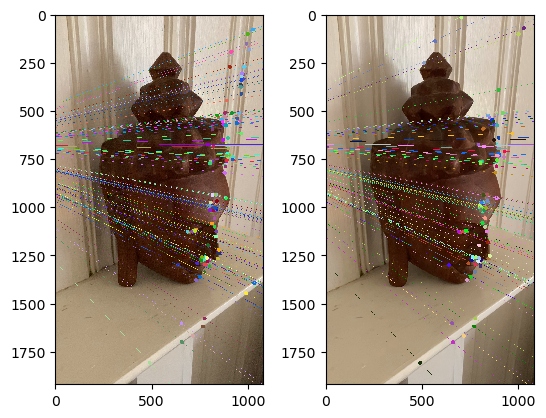

In [27]:
"""Computations related to F matrix, Normal F matrix and F_RANSAC"""

def normalize_points(points: np.ndarray):

    """Normalizes points and gives new points and the transformation matrix"""
    points_normalized, T = None, None

    u=np.array(points[:,0])
    v=np.array(points[:,1])
    c_u = np.mean(u)
    c_v = np.mean(v)

    s_u = 1.4142135623730951/np.mean(np.linalg.norm([u-c_u,v-c_v],axis = 0))
    scale=np.array([[s_u,0,0],[0,s_u,0],[0,0,1]])
    offset=np.array([[1,0,-c_u],[0,1,-c_v],[0,0,1]])
    T = np.matmul(scale,offset)
    points_normalized = np.matmul(T,points.T)

    return points_normalized.T, T

def compute_F_normalized(matches1, matches2, do_verify = False):######################################
    """"Computes F by normalizing the matches and then performing SVD and transforming it back to normal co-ordinates"""

    if matches1.shape[1]==2:
        match1 = np.hstack((matches1,np.ones((matches1.shape[0],1))))
        match2 = np.hstack((matches2,np.ones((matches2.shape[0],1))))
    else:
        match1 = matches1
        match2 = matches2

    match1, T1 = normalize_points(match1)
    match2, T2 = normalize_points(match2)

    x_flat = np.vstack((match1[:,0]*match2[:,0],match1[:,1]*match2[:,0],match2[:,0],match1[:,0]*match2[:,1],match1[:,1]*match2[:,1],match2[:,1],match1[:,0],match1[:,1],np.ones((matches1.shape[0]))))

    u,s,v= np.linalg.svd(x_flat.T)
    norm_sq = v[-1].reshape(3, 3)
    u,s,v= np.linalg.svd(norm_sq)
    s[np.argmin(s)]=0
    F_svd =  np.matmul(np.matmul(u, np.diag(s)),v)
    # F_svd = compute_F_raw(match1, match2)
    F_orig = np.matmul(np.matmul(T2.T,F_svd),T1)
    F_orig /= F_orig[2,2]

    if do_verify:
        # F_gt, mask = cv2.findFundamentalMat(matches2, matches1,cv2.LMEDS)
        F_gt, mask = cv2.findFundamentalMat(matches1, matches2,cv2.FM_8POINT)
        # print(F_gt)
        print("F_gt:")
        print(F_gt)
        print("F_pred:")
        # error = np.sum((F_svd-F_gt))
        # print(error)

    return F_orig

"""F_ransac Function"""

def compute_F_ransac(matches1, matches2, threshold=0.01, prob_success = 0.999, sample_size = 8, ind_prob_correct = .70):

    num_samples = np.log(1-prob_success)/np.log(1- np.float_power(ind_prob_correct,sample_size))

    # print(matches1.shape)
    if matches1.shape[1]==2:
        matches1_homo = np.hstack((matches1,np.ones((matches1.shape[0],1))))
        matches2_homo = np.hstack((matches2,np.ones((matches2.shape[0],1))))
    # print(matches1)
    max_inliers = 0

    for i in range(10000):
        sample_num = np.random.choice(matches1.shape[0],8)
        #print(sample_num)
        choices1 = matches1[sample_num]
        choices2 = matches2[sample_num]
        
        F = compute_F_normalized(choices1,choices2)

        # F_est,_ = cv2.findFundamentalMat(choices1, choices2, cv2.FM_8POINT)

        F_final = F

        if type(F_final) == np.ndarray:
            # if np.max(abs(F_est-F))>0.05:
            #     print("F calculation diverged")
            #     break
            # print(matches2.shape)
            # print(type(F_final))

            # error = np.multiply(np.matmul(matches2,F_final),matches1)
            # error=np.sum(error,axis=1) 
            error = np.matmul(np.matmul(matches2_homo,F),matches1_homo.T)
            error=np.diag(error)

            error_index = np.argwhere(abs(error)<=threshold)
            # print(error_index)
            inlier_count = error_index.shape[0]
            #print(len(error_index))
            #print(inlier_count)
            error_sum = np.sum(abs(error[error_index])) 
            if inlier_count>max_inliers:
                
                max_inliers = inlier_count
                best_F = F
                inliers1 = np.squeeze(matches1[error_index])
                inliers2 = np.squeeze(matches2[error_index]) 
                

    inliers1_homo = np.array(inliers1)#[:,0:2]/inliers1[:,2]
    inliers2_homo = np.array(inliers2)#[:,0:2]/inliers2[:,2]
    best_F, _ = cv2.findFundamentalMat(inliers1, inliers2, cv2.LMEDS)
    # inliers_a = np.sort(inliers_a)
    # inliers_b = np.sort(inliers_b)

    # index = np.random.choice(inliers1.shape[0], 30)

    # inliers1 = inliers1
    # inliers2 = inliers2

    return best_F, inliers1_homo, inliers2_homo

F_ransac, matches1_ransac_test, matches2_ransac_test = compute_F_ransac(pts_1_test, pts_2_test)
print("Number of Matches should be the same between the two images")
print(matches1_ransac_test.shape, matches2_ransac_test.shape)

lines1 = []
lines1 = cv2.computeCorrespondEpilines(matches1_ransac_test.reshape(-1,1,2), 2,F_ransac)
lines1 = lines1.reshape(-1,3)

# grey_images_list
img5,img6 = drawlines(images_list[0], images_list[1],lines1,matches1_ransac_test,matches2_ransac_test)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(matches2_ransac_test.reshape(-1,1,2), 1,F_ransac)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(images_list[1], images_list[0],lines2,matches2_ransac_test,matches1_ransac_test)

plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

# Front-end Pose Computation

In [7]:
'''Pose and 3D point computation functions'''

def compute_essential_mat(matches1, matches2):

    E, mask = cv2.findEssentialMat(matches1, matches2, K, cv2.RANSAC, 0.999, 1.0)
    matches1 = matches1[mask.ravel() == 1]
    matches2 = matches2[mask.ravel() == 1]
    
    return E, matches1, matches2, mask

def compute_pose(E, matches1, matches2, mask):

    _, R, t, mask = cv2.recoverPose(E, matches1, matches2, K)
    return matches1, matches2, R, t

def compute_pose_pnp(Q, q):
    
    success, rvec, t, inliers = cv2.solvePnPRansac(Q, q, K, None)
    # success, rvec, t = cv2.solvePnP(Q, q, self.K, self.dist_coeff)
    if success:
        R, _ = cv2.Rodrigues(rvec)
    
    # Compute the transformation matrix
    T_c_w = generate_transformation_matrix(R, t)    
    
    return T_c_w

def generate_transformation_matrix(R, t):
        
        T = np.eye(4, dtype=np.float64)
        T[:3, :3] = R
        T[:3, 3] = t if t.ndim == 1 else t.ravel()
        return T

def compute_projection_matrix(T):
    
    return K @ np.linalg.inv(T)[:3,:]

def triangulate_points(matches1, matches2, P1, P2):
    
    points_4d = cv2.triangulatePoints(P1, P2, matches1.T, matches2.T)

    points_3d = points_4d[:3, :] / points_4d[3, :]
    
    # # Remove points which are behind the camera
    mask = points_3d[2, :] > 0
    points_3d = points_3d[:, mask]
    q1 = matches1[mask]
    q2 = matches2[mask]
    
    return points_3d.T, q1, q2

'''points and pose computation'''
T = np.eye(4)
camera_poses = []
camera_poses.append(T)
for i in range(len(images_list)-1):
    
    pts_1, pts_2 = compute_matches(keypoints_list[i], keypoints_list[i+1], desc_list[i], desc_list[i+1])

    if i == 0:
        
        E, matches1, matches2, mask = compute_essential_mat(pts_1, pts_2)
        matches1, matches2, R, t = compute_pose(E, matches1, matches2, mask)
        T = generate_transformation_matrix(R, t)
        camera_poses.append(np.linalg.inv(T))
        P1 = compute_projection_matrix(camera_poses[i])
        P2 = compute_projection_matrix(camera_poses[i+1])
        points_3d, matches1, matches2 = triangulate_points(matches1, matches2, P1, P2)

        pointcloud = PointCloud(points_3d, 0, matches1, matches2)
        previous_keypoints = matches2

    else:

        E, matches1, matches2, mask = compute_essential_mat(pts_1, pts_2)

        matched_2d_image1, matched_3d, matched_indices = pointcloud.scan_pointcloud(i, previous_keypoints, matches1)

        print("Matched points 2d and 3d: ", matched_2d_image1.shape, matched_3d.shape)
        matched_2d_image2 = matches2[matched_indices]

        T_2_w = compute_pose_pnp(matched_3d, matched_2d_image2)
        camera_poses.append(np.linalg.inv(T_2_w))
        P1 = compute_projection_matrix(camera_poses[i])
        P2 = compute_projection_matrix(camera_poses[i+1])
        points3D, matches1, matches2 = triangulate_points(matches1, matches2, P1, P2)
        pointcloud.update(i, points3D, matches1, matches2)

        previous_keypoints = matches2

    print(matches1.shape, matches2.shape)





273
(109, 2) (109, 2)
183
Matched points 2d and 3d:  (39, 2) (39, 3)
(137, 2) (137, 2)
191
Matched points 2d and 3d:  (71, 2) (71, 3)
(147, 2) (147, 2)
102
Matched points 2d and 3d:  (23, 2) (23, 3)
(39, 2) (39, 2)
101
Matched points 2d and 3d:  (15, 2) (15, 3)
(47, 2) (47, 2)
105
Matched points 2d and 3d:  (16, 2) (16, 3)
(53, 2) (53, 2)
122
Matched points 2d and 3d:  (19, 2) (19, 3)
(55, 2) (55, 2)
90
Matched points 2d and 3d:  (11, 2) (11, 3)
(35, 2) (35, 2)
107
Matched points 2d and 3d:  (14, 2) (14, 3)
(45, 2) (45, 2)
122
Matched points 2d and 3d:  (22, 2) (22, 3)
(58, 2) (58, 2)
110
Matched points 2d and 3d:  (26, 2) (26, 3)
(65, 2) (65, 2)
141
Matched points 2d and 3d:  (24, 2) (24, 3)
(74, 2) (74, 2)
80
Matched points 2d and 3d:  (17, 2) (17, 3)
(40, 2) (40, 2)
78
Matched points 2d and 3d:  (13, 2) (13, 3)
(33, 2) (33, 2)
139
Matched points 2d and 3d:  (10, 2) (10, 3)
(66, 2) (66, 2)
125
Matched points 2d and 3d:  (24, 2) (24, 3)
(73, 2) (73, 2)
155
Matched points 2d and 3d:  (

In [8]:
print(len(pointcloud.cloud))

1075


# Back-end Bundle adjustment

In [9]:
L = gtsam.symbol_shorthand.L
X = gtsam.symbol_shorthand.X
camK = gtsam.Cal3_S2(K[0, 0], K[1, 1], 0.0, K[0, 2], K[1, 2])
measurement_noise = gtsam.noiseModel.Isotropic.Sigma(2, 10.0)
graph = gtsam.NonlinearFactorGraph()
pose_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.3, 0.1, 0.1, 0.1]))
factor = gtsam.PriorFactorPose3(X(0), gtsam.Pose3(camera_poses[0]), pose_noise)
graph.push_back(factor)

for j, point in enumerate(pointcloud.cloud):
    keys = list(point.origin.keys())
    for i in keys:
        measurement = point.origin[i]
        factor = gtsam.GenericProjectionFactorCal3_S2(measurement, measurement_noise, X(int(i)), L(j), camK)
        # factor = gtsam.GeneralSFMFactor2Cal3_S2(measurement, measurement_noise, X(int(i)), L(j), K_key)
        graph.push_back(factor)

point_noise = gtsam.noiseModel.Isotropic.Sigma(3, 1)
factor = gtsam.PriorFactorPoint3(L(0), gtsam.Point3(pointcloud.cloud[0].coords), point_noise)
graph.push_back(factor)

initial_estimate = gtsam.Values()
# initial_estimate.insert(K_key, K)
for i in range(len(images_list)):
    initial_estimate.insert(X(i), gtsam.Pose3(camera_poses[i]))
    
for j, point in enumerate(pointcloud.cloud):
    initial_estimate.insert(L(j), gtsam.Point3(point.coords))  


# params = gtsam.DoglegParams()
# params.setVerbosity('TERMINATION')
# optimizer = gtsam.DoglegOptimizer(graph, initial_estimate, params)
# print('Optimizing:')
# result = optimizer.optimize()
# result.print('Final results:\n')
# print('initial error = {}'.format(graph.error(initial_estimate)))
# print('final error = {}'.format(graph.error(result)))


params = gtsam.LevenbergMarquardtParams()
params.setVerbosityLM("SUMMARY")
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate, params)
result = optimizer.optimize()
print("Final error: ", graph.error(result))

for i in range(len(images_list)):
    camera_poses[i] = result.atPose3(X(i)).matrix()
    
# Update the pointcloud
for j, point in enumerate(pointcloud.cloud):
    pointcloud.cloud[j].coords = result.atPoint3(L(j))

Final error:  95.34272267546123
Initial error: 1439.16, values: 1099
iter      cost      cost_change    lambda  success iter_time
   0  5.478215e+05   -5.46e+05    1.00e-05     1    1.74e-02
iter      cost      cost_change    lambda  success iter_time
   0  3.916206e+03   -2.48e+03    1.00e-04     1    1.67e-02
iter      cost      cost_change    lambda  success iter_time
   0  5.642145e+02    8.75e+02    1.00e-03     1    1.75e-02
   1  3.325764e+02    2.32e+02    1.00e-04     1    1.10e-02
   2  2.392131e+03   -2.06e+03    1.00e-05     1    1.28e-02
   2  2.353173e+02    9.73e+01    1.00e-04     1    1.17e-02
   3  8.946507e+02   -6.59e+02    1.00e-05     1    1.02e-02
   3  1.881564e+02    4.72e+01    1.00e-04     1    1.11e-02
   4  3.884343e+02   -2.00e+02    1.00e-05     1    1.00e-02
   4  1.722465e+02    1.59e+01    1.00e-04     1    1.03e-02
   5  3.199669e+02   -1.48e+02    1.00e-05     1    1.16e-02
   5  1.652177e+02    7.03e+00    1.00e-04     1    1.11e-02
   6  1.762886e+

  1.02e-02
  23  1.117458e+02    1.84e+00    1.00e-05     1    9.22e-03
  24  7.205374e+05   -7.20e+05    1.00e-06     1    9.46e-03
  24  1.084462e+02    3.30e+00    1.00e-05     1    9.54e-03
  25  7.207570e+05   -7.21e+05    1.00e-06     1    1.17e-02
  25  1.099852e+02   -1.54e+00    1.00e-05     1    9.63e-03
  25  1.080118e+02    4.34e-01    1.00e-04     1    9.82e-03
  26  1.069421e+02    1.07e+00    1.00e-05     1    1.04e-02
  27  1.266684e+03   -1.16e+03    1.00e-06     1    9.48e-03
  27  1.080311e+03   -9.73e+02    1.00e-05     1    1.03e-02
  27  1.275643e+02   -2.06e+01    1.00e-04     1    9.98e-03
  27  9.918311e+01    7.76e+00    1.00e-03     1    9.68e-03
  28  9.758198e+01    1.60e+00    1.00e-04     1    9.28e-03
  29  1.800953e+05   -1.80e+05    1.00e-05     1    9.65e-03
  29  9.675648e+01    8.25e-01    1.00e-04     1    9.49e-03
  30  1.800952e+05   -1.80e+05    1.00e-05     1    1.00e-02
  30  9.612586e+01    6.31e-01    1.00e-04     1    9.81e-03
  31  1.80094

In [10]:
def calculate_point_colors(cloud):
    cloud_colors = []
    for point in cloud:
        r, g, b = 0, 0, 0
        for key in point.origin.keys():
            image = images_list[key]
            point2d = point.origin[key]
            r += image[int(point2d[1]), int(point2d[0]), 0]
            g += image[int(point2d[1]), int(point2d[0]), 1]
            b += image[int(point2d[1]), int(point2d[0]), 2]
        
        # Average the color by dividing by the number of views    
        r /= len(point.origin.keys())
        g /= len(point.origin.keys())
        b /= len(point.origin.keys())
        
        # Append the color to the list
        cloud_colors.append([r, g, b])
    
    cloud_colors = np.array(cloud_colors)
    return cloud_colors

cloud_colors = calculate_point_colors(pointcloud.cloud)
%matplotlib qt
plot_camera_poses_with_pointcloud(camera_poses, pointcloud.get_pointcloud(), cloud_colors, plot_cloud=True)


# Don't run the below Cell

In [43]:
# '''Code to implement SuperGlue on images, currently adding config and Matching from Superglue'''
# device = 'cuda' if torch.cuda.is_available() and not True else 'cpu'
# print('Running inference on device \"{}\"'.format(device))
# config = {
#     'superpoint': {
#         'nms_radius': 4,
#         'keypoint_threshold': 0.005,
#         'max_keypoints': -1
#     },
#     'superglue': {
#         'weights': 'indoor',
#         'sinkhorn_iterations': 20,
#         'match_threshold': 0.2,
#     }
# }
# matching = Matching(config).eval().to(device)

# def superglue_matches(img1, img2, matching, device):
    
#     keys = ['keypoints', 'scores', 'descriptors']

#     frame_tensor = frame2tensor(img1, device)
#     last_data = matching.superpoint({'image': frame_tensor})
#     last_data = {k+'0': last_data[k] for k in keys}
#     last_data['image0'] = frame_tensor
#     last_frame = img1
#     last_image_id = 0

#     frame_tensor = frame2tensor(img2, device)
#     pred = matching({**last_data, 'image1': frame_tensor})
#     kpts0 = last_data['keypoints0'][0].cpu().numpy()
#     kpts1 = pred['keypoints1'][0].cpu().numpy()
#     matches = pred['matches0'][0].cpu().numpy()
#     confidence = pred['matching_scores0'][0].cpu().detach().numpy()

#     valid = matches > -1

#     mkpts0 = kpts0[valid]
#     # print(mkpts0[0])
#     mkpts1 = kpts1[matches[valid]]
#     # print(mkpts1[0])
#     # color = cm.jet(confidence[valid])

#     text = [
#         'SuperGlue',
#         'Keypoints: {}:{}'.format(len(kpts0), len(kpts1)),
#         'Matches: {}'.format(len(mkpts0))
#     ]
#     k_thresh = matching.superpoint.config['keypoint_threshold']
#     m_thresh = matching.superglue.config['match_threshold']
#     small_text = [
#         'Keypoint Threshold: {:.4f}'.format(k_thresh),
#         'Match Threshold: {:.2f}'.format(m_thresh),
#         'Image Pair: {:06}:{:06}'.format(1, 2),
#     ]
#     # out = make_matching_plot_fast(
#     #     img1, img2, kpts0, kpts1, mkpts0, mkpts1, color, text,
#     #     path=None, show_keypoints=True, small_text=small_text)
    
#     return mkpts0, mkpts1

# matches_img1, matches_img2 = superglue_matches(images_list[0],images_list[1], matching, device)
# print(matches_img1.shape)